### Tasks - project 4

Identifying regulatory interactions
Single cell RNA sequencing data allows the measurement of all genes in many cells at the same time. Genes are often co-regulated, or regulate each other. Correlation, anti-correlation or mutual information between pairs of genes can hint regulatory interactions, and help in reconstructing regulatory networks.

*	Background single cell RNA sequencing
*	Data – any single cell RNA-sequencing data.
*	Filter out genes that are not expressed
*	Replace values lower than one by one. log2 transform the data
*	Identify pairs of genes that are significantly correlated (alternatively, anti-correlated or have mutual information). Take into account the problem of multiple comparisons
*	Test if those gene pairs are also correlated in the other dataset. 
*	For at least one correlated pair of genes, see if you can find research about interaction or functional relationships between those genes. 


In [2]:
from sys import getsizeof
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import mutual_info_score

In [6]:
def calc_MI(x, y, bins=12):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

In [7]:
x, y = range(1000), range(1000)

calc_MI(x, y, 10)

2.302585092994045

In [8]:
np.corrcoef(x,y)

array([[ 1.,  1.],
       [ 1.,  1.]])

In [9]:
% ls data/

GSE81383_data_melanoma_scRNAseq_BT_Mel.txt
GSE82187_cast_all_forGEO.csv
GSE83533_AML_130_Rel_rpkm.txt
unused/


In [17]:
path = '/Users/mdymshits/comp_bio/data/GSE82187_cast_all_forGEO.csv'
df = pd.read_csv(path)

In [32]:
from collections import Counter
Counter(df['type'])

Counter({'Astro': 107,
         'Ependy-C': 18,
         'Ependy-Sec': 21,
         'Macrophage': 71,
         'Microglia': 48,
         'NSC': 7,
         'Neuron': 837,
         'OPC': 13,
         'Oligo': 43,
         'Vascular': 43})

In [5]:
df.shape

(1208, 18845)

In [28]:
df.iloc[:3,:10]



,Unnamed: 0,cell.name,type,experiment,protocol,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik
0,1,1-0-0-0-BTN22-C34-8ul-1,Neuron,BTN22,Mic-scRNA-Seq,0.0,0.00000,0.0,0.0,0.000000
1,2,1-0-0-0-BTN24-C29-18ul-IL5195-708-502,Neuron,BTN24,Mic-scRNA-Seq,0.0,1.82800,0.0,0.0,1.751656
2,3,1-0-0-0-BTN24-C59-22ul-IL5195-710-505,Neuron,BTN24,Mic-scRNA-Seq,0.0,2.01606,0.0,0.0,0.000000


In [100]:
cnt = 0
zeros = []
for i, col in tqdm(enumerate(df)):
    if (df[col] == 0).all():
#         print i, col, cnt
        cnt += 1
        zeros.append(col)
print cnt
df = df.drop(zeros, axis=1)
col_names = list(df.columns.values)[5:]

18845it [00:03, 5047.70it/s]


457


In [6]:
df_np = df.values
%time cor = np.corrcoef(df_np.T)

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [29]:
cor_genes = {}
for i in tqdm(range(cor.shape[0])):
    for j in range(cor.shape[0]):
        if j >= i:
            continue
        if abs(cor[i,j]) > .95:
            cor_genes['_'.join([col_names[i], col_names[j]])] = cor[i,j]
#             print cor[i,j], col_names[i], col_names[j]

100%|██████████| 18383/18383 [01:39<00:00, 185.37it/s]


In [30]:
len(cor_genes)

1865

In [14]:
non_cor_genes = {}
for i in tqdm(range(cor.shape[0])):
    for j in range(cor.shape[0]):
        if j >= i:
            continue
        if abs(cor[i,j]) < .1:
            non_cor_genes['_'.join([col_names[i], col_names[j]])] = cor[i,j]
#             print cor[i,j], col_names[i], col_names[j]

100%|██████████| 18383/18383 [09:14<00:00, 33.18it/s]


In [26]:
len(non_cor_genes) / 10 ** 6

137

In [36]:
getsizeof(non_cor_genes) / 10. ** 9

6.442451224

In [35]:
getsizeof(cor_genes) / 10. ** 3

196.888

In [112]:
mi = []
for i, key in enumerate(non_cor_genes):
    gen1, gen2 = key.split('_')
    val = calc_MI(df[gen1].values, df[gen2].values, bins = 3)
    mi.append(val)
#     print gen1, gen2, val
    
    if i > 1000:
        break
# print mi
print np.mean(mi), np.std(mi)   

0.00237006774512 0.00385298704285


In [115]:
mi = []
for i, key in enumerate(cor_genes):
    try:
        gen1, gen2 = key.split('_')
    except:
        print '!!'
        continue
    val = calc_MI(df[gen1].values, df[gen2].values, bins = 3)
    mi.append(val)
#     print gen1, gen2, val
#     print df[gen1]
    if i > 1000:
        break
print np.mean(mi), np.std(mi)
# print mi

!!
0.016051137446 0.0590543390949


In [125]:
df.iloc[:3, :7]

,Unnamed: 0,cell.name,type,experiment,protocol,0610005C13Rik,0610007C21Rik
0,1,1-0-0-0-BTN22-C34-8ul-1,Neuron,BTN22,Mic-scRNA-Seq,0.0,0.00000
1,2,1-0-0-0-BTN24-C29-18ul-IL5195-708-502,Neuron,BTN24,Mic-scRNA-Seq,0.0,1.82800
2,3,1-0-0-0-BTN24-C59-22ul-IL5195-710-505,Neuron,BTN24,Mic-scRNA-Seq,0.0,2.01606


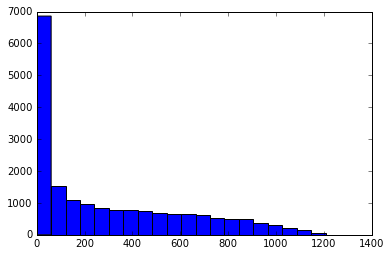

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
bins = 20
# bins = range(1, 10, 2 ) + range(11,100, 10) + range(101, 1200, 50)
plt.hist(df.iloc[:,5:].T.astype(bool).sum(axis=1), bins=bins);
# plt.xlim(0, 200)

In [128]:
bins

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 11,
 111,
 211,
 311,
 411,
 511,
 611,
 711,
 811,
 911,
 1011,
 1111]

In [70]:
calc_MI(range(10000),[0] * 10000, bins=200)

1.3877787807814457e-15

In [111]:
for i in df['Kcnj8']:
    print i

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
